## 1. Import Required Libraries


In [1]:
# Sklearn
from sklearn.preprocessing import LabelEncoder

# PyTorch
import torch
from torch.utils.data import Dataset
from torch.optim import AdamW
from torch.utils.data import DataLoader


# Transformers
from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    get_linear_schedule_with_warmup,
)
import os
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime

import numpy as np
from sklearn.metrics import (
    f1_score,
    precision_score,
    confusion_matrix,
    classification_report,
)

d:\University of Calgary\Winter 2026\ENSF617-Introduction-To-Machine-Learning\trash-classification-project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Device Configuration


In [2]:
# Set style for better visualizations
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: NVIDIA GeForce RTX 3050 Ti Laptop GPU


## 3. Dataset Creation and Preparation


### 3.1 Dataset Paths


In [3]:
# Root dataset folder
text_dataset_root = Path("../dataset_text")
image_dataset_root = Path("../dataset")

### 3.2 Create Text Dataset from Image Filenames


In [4]:
def create_text_dataset_from_image_filename(
    image_dataset_root: Path, text_dataset_root: Path, filename: str
) -> pd.DataFrame:
    # In the image dataset directory, the images are in sub directories named after the class labels (e.g., "Black", "Blue", etc.).
    # We will read the image filenames and their corresponding class labels, and create a text dataset where each row contains the image filename and its class label.
    data = []
    for class_dir in os.listdir(image_dataset_root):
        class_path = image_dataset_root / class_dir
        if class_path.is_dir():
            for image_file in os.listdir(class_path):
                if image_file.endswith((".jpg", ".jpeg", ".png")):
                    # Remove file extension from image filename
                    text_name = os.path.splitext(image_file)[0]
                    data.append({"text": text_name, "label": class_dir})

    # Shuffle the dataset
    df = pd.DataFrame(data).sample(frac=1, random_state=42).reset_index(drop=True)

    # Save the text dataset as a CSV file in the text dataset directory
    text_dataset_path = text_dataset_root / filename
    df.to_csv(text_dataset_path, index=False)
    return df

In [5]:
train_images_path = image_dataset_root / "CVPR_2024_dataset_Train"
val_images_path = image_dataset_root / "CVPR_2024_dataset_Val"
test_images_path = image_dataset_root / "CVPR_2024_dataset_Test"

train_df = create_text_dataset_from_image_filename(
    train_images_path, text_dataset_root, "train.csv"
)
val_df = create_text_dataset_from_image_filename(
    val_images_path, text_dataset_root, "val.csv"
)
test_df = create_text_dataset_from_image_filename(
    test_images_path, text_dataset_root, "test.csv"
)

print("Train Dataset")
print(train_df.head(), "\n")

print("\nValidation Dataset")
print(val_df.head(), "\n")

print("\nTest Dataset")
print(test_df.head(), "\n")

Train Dataset
                               text  label
0                       yogurt_5334   Blue
1               Expired_Garlic_3168  Green
2  empty_plastic_yogurt_bottle_3200   Blue
3       empty_chocolate_wrapper_575  Black
4                       Grapes_1117  Green 


Validation Dataset
                             text  label
0                  aerosol_can_17    TTR
1                plastic food box   Blue
2                       mask_1106  Black
3                 beer_bottle_241   Blue
4  dirty_bottle_of_hand_soap_1321   Blue 


Test Dataset
                  text  label
0  paper_gift_bag_1859   Blue
1    candy_wrapper_111  Black
2      tissue_box_2508  Black
3  poly_packaging_2658   Blue
4   empty_pea_can_1018   Blue 



### 3.3 Label Encoding


In [6]:
# Encode the class labels
label_encoder = LabelEncoder()
train_df["label"] = label_encoder.fit_transform(train_df["label"])
val_df["label"] = label_encoder.transform(val_df["label"])
test_df["label"] = label_encoder.transform(test_df["label"])

print("Encoded Train Dataset")
print(train_df.head(), "\n")

print("\nEncoded Validation Dataset")
print(val_df.head(), "\n")

print("\nEncoded Test Dataset")
print(test_df.head(), "\n")

Encoded Train Dataset
                               text  label
0                       yogurt_5334      1
1               Expired_Garlic_3168      2
2  empty_plastic_yogurt_bottle_3200      1
3       empty_chocolate_wrapper_575      0
4                       Grapes_1117      2 


Encoded Validation Dataset
                             text  label
0                  aerosol_can_17      3
1                plastic food box      1
2                       mask_1106      0
3                 beer_bottle_241      1
4  dirty_bottle_of_hand_soap_1321      1 


Encoded Test Dataset
                  text  label
0  paper_gift_bag_1859      1
1    candy_wrapper_111      0
2      tissue_box_2508      0
3  poly_packaging_2658      1
4   empty_pea_can_1018      1 



### 3.4 Number of Classes


In [7]:
NUM_CLASSES = len(label_encoder.classes_)
print("Number of classes:", NUM_CLASSES)

Number of classes: 4


## 4. Data Loading with PyTorch


### 4.1 Tokenizer Setup


In [8]:
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

### 4.2 Custom Dataset Class


In [9]:
class GarbageDataset(Dataset):
    def __init__(self, texts, labels):
        self.encodings = tokenizer(
            texts.tolist(), truncation=True, padding=True, max_length=64
        )
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(
            self.labels[idx], dtype=torch.long
        )  # 🔥 important
        return item

    def __len__(self):
        return len(self.labels)

### 4.3 Create DataLoaders


In [10]:
BATCH_SIZE = 64  # Increased for more stable gradients

In [11]:
train_dataset = GarbageDataset(train_df["text"].values, train_df["label"].values)

val_dataset = GarbageDataset(val_df["text"].values, val_df["label"].values)

test_dataset = GarbageDataset(test_df["text"].values, test_df["label"].values)


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## 5. Model Architecture and Setup


### 5.1 Model Initialization


In [12]:
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=NUM_CLASSES
)

Loading weights: 100%|██████████| 100/100 [00:00<00:00, 973.72it/s, Materializing param=distilbert.transformer.layer.5.sa_layer_norm.weight]   
DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_layer_norm.bias   | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
pre_classifier.bias     | MISSING    | 
classifier.bias         | MISSING    | 
pre_classifier.weight   | MISSING    | 
classifier.weight       | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


## 6. Training Functions

### 6.1 Training Epoch Function

In [13]:
from sklearn.metrics import accuracy_score


def train_epoch(model, loader, optimizer, scheduler):
    model.train()
    total_loss = 0

    all_preds = []
    all_labels = []

    for batch in loader:
        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(
            input_ids=input_ids, attention_mask=attention_mask, labels=labels
        )

        loss = outputs.loss
        logits = outputs.logits

        total_loss += loss.item()

        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        loss.backward()

        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        scheduler.step()

    train_acc = accuracy_score(all_labels, all_preds)

    return total_loss / len(loader), train_acc

### 6.2 Validation Epoch Function

In [14]:
from sklearn.metrics import f1_score


def eval_epoch(model, loader):
    model.eval()
    total_loss = 0
    preds = []
    true_labels = []

    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(
                input_ids=input_ids, attention_mask=attention_mask, labels=labels
            )

            loss = outputs.loss
            logits = outputs.logits

            total_loss += loss.item()

            predictions = torch.argmax(logits, dim=1)

            preds.extend(predictions.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(true_labels, preds)
    f1 = f1_score(true_labels, preds, average="weighted")

    return total_loss / len(loader), acc, f1

### 6.3 Checkpoint Saving Function

In [15]:
CHECKPOINT_DIR = Path("../text_models")

In [16]:
def save_checkpoint(model, optimizer, scheduler, epoch, val_acc, filepath: Path):
    """
    Save model checkpoint with training state.

    Args:
        model: The model to save
        optimizer: The optimizer state
        scheduler: The scheduler state
        epoch: Current epoch number
        val_acc: Validation accuracy
        filepath: Path to save the checkpoint
    """
    checkpoint = {
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "scheduler_state_dict": scheduler.state_dict(),
        "val_acc": val_acc,
    }

    # Create checkpoint directory if it doesn't exist
    filepath.parent.mkdir(parents=True, exist_ok=True)

    # Save checkpoint
    torch.save(checkpoint, filepath)
    print(f"✓ Checkpoint saved to {filepath}")


print("Checkpoint saving function created!")

Checkpoint saving function created!


## 7. Main Training Loop


In [17]:
# Training Configuration

EPOCHS = 15  # Increased from 5 for better convergence
total_steps = len(train_loader) * EPOCHS
WEIGHT_DECAY = 0.01
LEARNING_RATE = 3e-5  # Slightly increased from 2e-5
EARLY_STOP_PATIENCE = 4  # Increased from 2 to allow more plateau exploration
WARMUP_RATIO = 0.1  # 10% of total steps for warmup
MAX_GRAD_NORM = 1.0  # Gradient clipping threshold

# Calculate warmup steps
num_warmup_steps = int(WARMUP_RATIO * total_steps)

optimizer = AdamW(
    params=model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
)

scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=total_steps
)

print("Training configuration:")
print(f"- Epochs: {EPOCHS}")
print(f"- Batch Size: {BATCH_SIZE}")
print(f"- Learning Rate: {LEARNING_RATE}")
print(f"- Weight Decay: {WEIGHT_DECAY}")
print(f"- Early Stopping Patience: {EARLY_STOP_PATIENCE} epochs")

print(f"- Warmup Steps: {num_warmup_steps} ({WARMUP_RATIO*100:.0f}% of total)")
print(f"- Scheduler: Linear warmup + linear decay")

print(f"- Total Steps: {total_steps}")
print(f"- Optimizer: AdamW")
print(f"- Max Gradient Norm: {MAX_GRAD_NORM}")

Training configuration:
- Epochs: 15
- Batch Size: 64
- Learning Rate: 3e-05
- Weight Decay: 0.01
- Early Stopping Patience: 4 epochs
- Warmup Steps: 274 (10% of total)
- Scheduler: Linear warmup + linear decay
- Total Steps: 2745
- Optimizer: AdamW
- Max Gradient Norm: 1.0


In [18]:
torch.cuda.empty_cache()
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSelfAttention(
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [19]:
# Training history tracking
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
learning_rates = []

# Best model tracking
best_acc = 0
best_epoch = 0
patience_counter = 0

# Training start time
start_time = time.time()
print(f"🚀 Starting training at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("=" * 80)

for epoch in range(1, EPOCHS + 1):
    epoch_start = time.time()

    print(f"\nEpoch [{epoch}/{EPOCHS}]")
    print("-" * 80)

    # Train
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, scheduler)

    # Validate
    val_loss, val_acc, val_f1 = eval_epoch(model, val_loader)

    # Get current learning rate
    current_lr = optimizer.param_groups[0]["lr"]

    # Save metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    learning_rates.append(current_lr)

    # Calculate epoch time
    epoch_time = time.time() - epoch_start

    # Print epoch summary
    print(f"\n  Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
    print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc*100:.2f}%")
    print(f"  Val F1:     {val_f1:.4f} | LR: {current_lr:.6f}")
    print(f"  Time: {epoch_time:.2f}s")

    # Save periodic checkpoint (every 5 epochs)
    SAVE_EVERY = 5
    if epoch % SAVE_EVERY == 0:
        checkpoint_path = CHECKPOINT_DIR / f"distilbert_epoch_{epoch}.pth"
        save_checkpoint(model, optimizer, scheduler, epoch - 1, val_acc, checkpoint_path)
    
    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        best_epoch = epoch
        patience_counter = 0

        # Save best model
        best_model_path = CHECKPOINT_DIR / "distilbert_best.pth"
        save_checkpoint(model, optimizer, scheduler, epoch - 1, val_acc, best_model_path)
        print(f"  🌟 New best model! Validation accuracy: {best_acc*100:.2f}%")
    else:
        patience_counter += 1
        print(f"  No improvement ({patience_counter}/{EARLY_STOP_PATIENCE})")

        if patience_counter >= EARLY_STOP_PATIENCE:
            print(
                f"\n⚠️  Early stopping triggered! No improvement for {EARLY_STOP_PATIENCE} epochs."
            )
            break


# Training completeprint("=" * 80)

total_time = time.time() - start_time
print(f"Best validation accuracy: {best_acc*100:.2f}% (Epoch {best_epoch})")

print("\n" + "=" * 80)
print(f"Total time: {total_time / 60:.2f} minutes")
print(f"✅ Training completed!")

🚀 Starting training at 2026-02-17 19:22:38

Epoch [1/15]
--------------------------------------------------------------------------------

  Train Loss: 0.9626 | Train Acc: 59.32%
  Val Loss:   0.4127 | Val Acc:   86.26%
  Val F1:     0.8603 | LR: 0.000020
  Time: 28.50s
✓ Checkpoint saved to ..\text_models\distilbert_best.pth
  🌟 New best model! Validation accuracy: 86.26%

Epoch [2/15]
--------------------------------------------------------------------------------

  Train Loss: 0.3461 | Train Acc: 88.71%
  Val Loss:   0.2810 | Val Acc:   90.77%
  Val F1:     0.9066 | LR: 0.000029
  Time: 30.24s
✓ Checkpoint saved to ..\text_models\distilbert_best.pth
  🌟 New best model! Validation accuracy: 90.77%

Epoch [3/15]
--------------------------------------------------------------------------------

  Train Loss: 0.2242 | Train Acc: 92.70%
  Val Loss:   0.2431 | Val Acc:   91.92%
  Val F1:     0.9200 | LR: 0.000027
  Time: 31.15s
✓ Checkpoint saved to ..\text_models\distilbert_best.pth
  🌟

## 8. Training Results Visualization


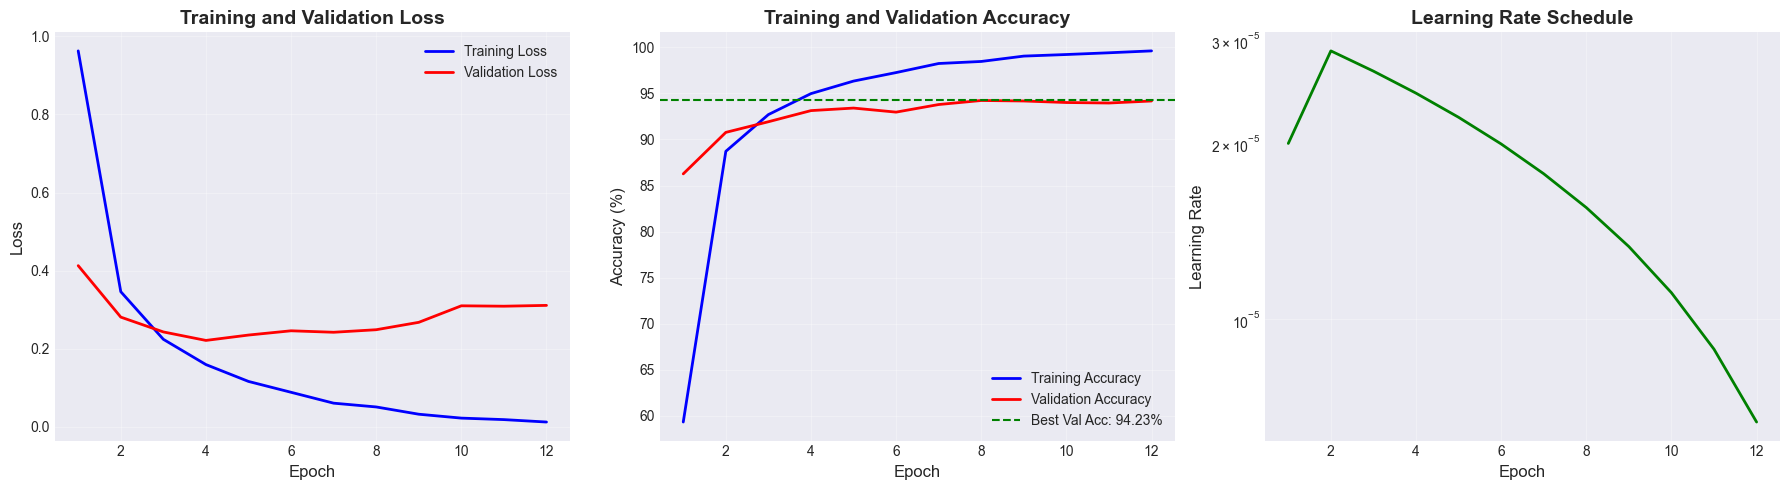


✅ Training history plot saved to ..\text_models\training_history.png


In [20]:
# Plot training history
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

epochs_range = range(1, len(train_losses) + 1)

# Plot 1: Loss curves
axes[0].plot(epochs_range, train_losses, "b-", label="Training Loss", linewidth=2)
axes[0].plot(epochs_range, val_losses, "r-", label="Validation Loss", linewidth=2)
axes[0].set_xlabel("Epoch", fontsize=12)
axes[0].set_ylabel("Loss", fontsize=12)
axes[0].set_title("Training and Validation Loss", fontsize=14, fontweight="bold")
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Plot 2: Accuracy curves (convert to percentage)
train_acc_pct = [acc * 100 for acc in train_accuracies]
val_acc_pct = [acc * 100 for acc in val_accuracies]

axes[1].plot(epochs_range, train_acc_pct, "b-", label="Training Accuracy", linewidth=2)
axes[1].plot(epochs_range, val_acc_pct, "r-", label="Validation Accuracy", linewidth=2)
axes[1].axhline(
    y=best_acc * 100,
    color="g",
    linestyle="--",
    label=f"Best Val Acc: {best_acc*100:.2f}%",
)
axes[1].set_xlabel("Epoch", fontsize=12)
axes[1].set_ylabel("Accuracy (%)", fontsize=12)
axes[1].set_title("Training and Validation Accuracy", fontsize=14, fontweight="bold")
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

# Plot 3: Learning rate schedule
axes[2].plot(epochs_range, learning_rates, "g-", linewidth=2)
axes[2].set_xlabel("Epoch", fontsize=12)
axes[2].set_ylabel("Learning Rate", fontsize=12)
axes[2].set_title("Learning Rate Schedule", fontsize=14, fontweight="bold")
axes[2].set_yscale("log")
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(CHECKPOINT_DIR / "training_history.png", dpi=300, bbox_inches="tight")
plt.show()

print(
    f"\n✅ Training history plot saved to {CHECKPOINT_DIR / 'training_history.png'}"
)

## 9. Model Evaluation Functions


### 9.1 Comprehensive Model Evaluation Function


In [21]:
def evaluate_model(model, dataloader, class_names, device, plot_confusion_matrix=True):
    """
    Comprehensive model evaluation with multiple metrics.

    Args:
        model: The model to evaluate
        dataloader: DataLoader for test/validation set
        class_names: List of class names for labeling
        device: Device to run evaluation on
        plot_confusion_matrix: Whether to plot confusion matrix heatmap

    Returns:
        Dictionary containing:
        - accuracy: Overall accuracy
        - macro_f1: Macro-averaged F1 score
        - per_class_precision: Precision for each class
        - inference_time: Average inference time per sample (ms)
        - confusion_matrix: Confusion matrix array
        - classification_report: Detailed per-class metrics
    """

    model.eval()

    all_preds = []
    all_labels = []
    all_probs = []
    total_inference_time = 0
    total_samples = 0

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # Time inference
            start_time = time.time()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            inference_time = time.time() - start_time

            logits = outputs.logits

            probs = torch.softmax(logits, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

            total_inference_time += inference_time
            total_samples += len(labels)

    # Convert to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    macro_f1 = f1_score(all_labels, all_preds, average="macro")
    per_class_precision = precision_score(all_labels, all_preds, average=None)
    avg_inference_time_ms = (total_inference_time / total_samples) * 1000
    conf_matrix = confusion_matrix(all_labels, all_preds)
    class_report = classification_report(
        all_labels, all_preds, target_names=class_names, digits=4
    )

    # Print results
    print("=" * 60)
    print("EVALUATION RESULTS")
    print("=" * 60)
    print(f"Overall Accuracy: {accuracy:.4f}")
    print(f"Macro F1 Score: {macro_f1:.4f}")
    print(f"Average Inference Time: {avg_inference_time_ms:.4f} ms/sample")
    print("\nPer-Class Precision:")
    for i, class_name in enumerate(class_names):
        print(f"  {class_name}: {per_class_precision[i]:.4f}")
    print("\n" + "=" * 60)
    print("CLASSIFICATION REPORT")
    print("=" * 60)
    print(class_report)
    print("=" * 60)

    # Plot confusion matrix if requested
    if plot_confusion_matrix:
        plt.figure(figsize=(10, 8))
        sns.heatmap(
            conf_matrix,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names,
            cbar_kws={"label": "Count"},
        )
        plt.title("Confusion Matrix", fontsize=14, fontweight="bold")
        plt.ylabel("True Label", fontsize=12)
        plt.xlabel("Predicted Label", fontsize=12)
        plt.tight_layout()
        plt.show()

    # Return comprehensive results dictionary
    return {
        "accuracy": accuracy,
        "macro_f1": macro_f1,
        "per_class_precision": per_class_precision,
        "inference_time": avg_inference_time_ms,
        "confusion_matrix": conf_matrix,
        "classification_report": class_report,
        "predictions": all_preds,
        "true_labels": all_labels,
        "probabilities": all_probs,
    }

### 9.2 Load and Evaluate Best Model on Test Set


In [22]:
best_model_path = CHECKPOINT_DIR / "distilbert_best.pth"


Evaluating best model on test set...
EVALUATION RESULTS
Overall Accuracy: 0.7723
Macro F1 Score: 0.7711
Average Inference Time: 0.0940 ms/sample

Per-Class Precision:
  Black: 0.6162
  Blue: 0.7618
  Green: 0.8679
  TTR: 0.8402

CLASSIFICATION REPORT
              precision    recall  f1-score   support

       Black     0.6162    0.6857    0.6491       700
        Blue     0.7618    0.7388    0.7501      1091
       Green     0.8679    0.8993    0.8833       804
         TTR     0.8402    0.7666    0.8017       857

    accuracy                         0.7723      3452
   macro avg     0.7715    0.7726    0.7711      3452
weighted avg     0.7764    0.7723    0.7735      3452



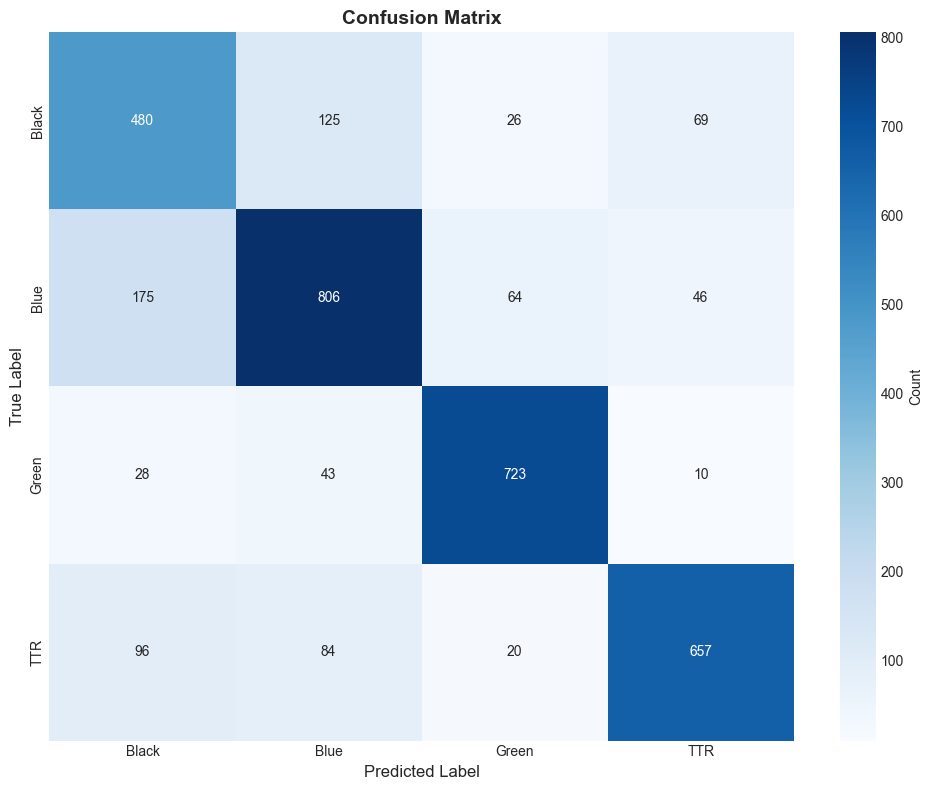

In [23]:
if best_model_path.exists():
    # Load the best model
    checkpoint = torch.load(best_model_path)
    model.load_state_dict(checkpoint["model_state_dict"])
    model.to(device)

    # Get class names from label encoder
    class_names = label_encoder.classes_.tolist()

    # Evaluate the model with comprehensive metrics
    print("\nEvaluating best model on test set...")

    results = evaluate_model(
        model, test_loader, class_names, device, plot_confusion_matrix=True
    )
else:
    print(f"Best model checkpoint not found at {best_model_path}")
    print("Please train the model first or specify correct checkpoint path.")

## 10. Model Inference Demo on Test Set

### 10.1 Model Prediction Functions (Logits & Probabilities)

In [24]:
from typing import Literal, Union, Tuple


def get_predictions(
    model,
    texts: list,
    tokenizer,
    device,
    return_type: Literal["logits", "probs", "both"] = "both",
) -> Union[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
    """
    Get model predictions with options for logits and/or probabilities.

    Args:
        model: The trained model
        texts: List of input text strings
        tokenizer: Tokenizer for encoding texts
        device: Device to run inference on
        return_type: 'logits', 'probs', or 'both'

    Returns:
        Depending on return_type:
        - 'logits': raw logits (pre-softmax scores/weights)
        - 'probs': probability distribution (post-softmax)
        - 'both': tuple of (logits, probs)
    """
    model.eval()

    # Tokenize the texts
    encodings = tokenizer(
        texts, truncation=True, padding=True, max_length=64, return_tensors="pt"
    )

    input_ids = encodings["input_ids"].to(device)
    attention_mask = encodings["attention_mask"].to(device)

    with torch.no_grad():
        # Get raw logits (these are the "weights" over classes before softmax)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Apply softmax to get probability distribution
        probs = torch.softmax(logits, dim=1)

        if return_type == "logits":
            return logits
        elif return_type == "probs":
            return probs
        else:  # 'both'
            return logits, probs


def predict_single_text(model, text: str, tokenizer, device, class_names) -> dict:
    """
    Predict a single text and return detailed results.

    Args:
        model: Trained model
        text: Input text string
        tokenizer: Tokenizer for encoding text
        device: Device to run inference on
        class_names: List of class names

    Returns:
        dict with predicted class, logits, and probabilities
    """
    # Get both logits and probabilities
    logits, probs = get_predictions(
        model, [text], tokenizer, device, return_type="both"
    )

    # Get predicted class
    predicted_class = torch.argmax(probs, dim=1).item()

    return {
        "text": text,
        "predicted_class_idx": predicted_class,
        "predicted_class_name": class_names[predicted_class],
        "logits": logits.cpu().numpy()[0],  # Raw scores for each class
        "probabilities": probs.cpu().numpy()[0],  # Probability distribution
    }


print("Prediction functions created!")
print("- get_predictions(): Get logits and/or probabilities for a batch")
print("- predict_single_text(): Detailed prediction for single text")

Prediction functions created!
- get_predictions(): Get logits and/or probabilities for a batch
- predict_single_text(): Detailed prediction for single text


### 10.2 Test Model Predictions with Logits and Probabilities

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19868\3051282402.py:53: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19868\3051282402.py:53: UserWarning: Glyph 10007 (\N{BALLOT X}) missing from font(s) Arial.
  plt.tight_layout()
d:\University of Calgary\Winter 2026\ENSF617-Introduction-To-Machine-Learning\trash-classification-project\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
d:\University of Calgary\Winter 2026\ENSF617-Introduction-To-Machine-Learning\trash-classification-project\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10007 (\N{BALLOT X}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


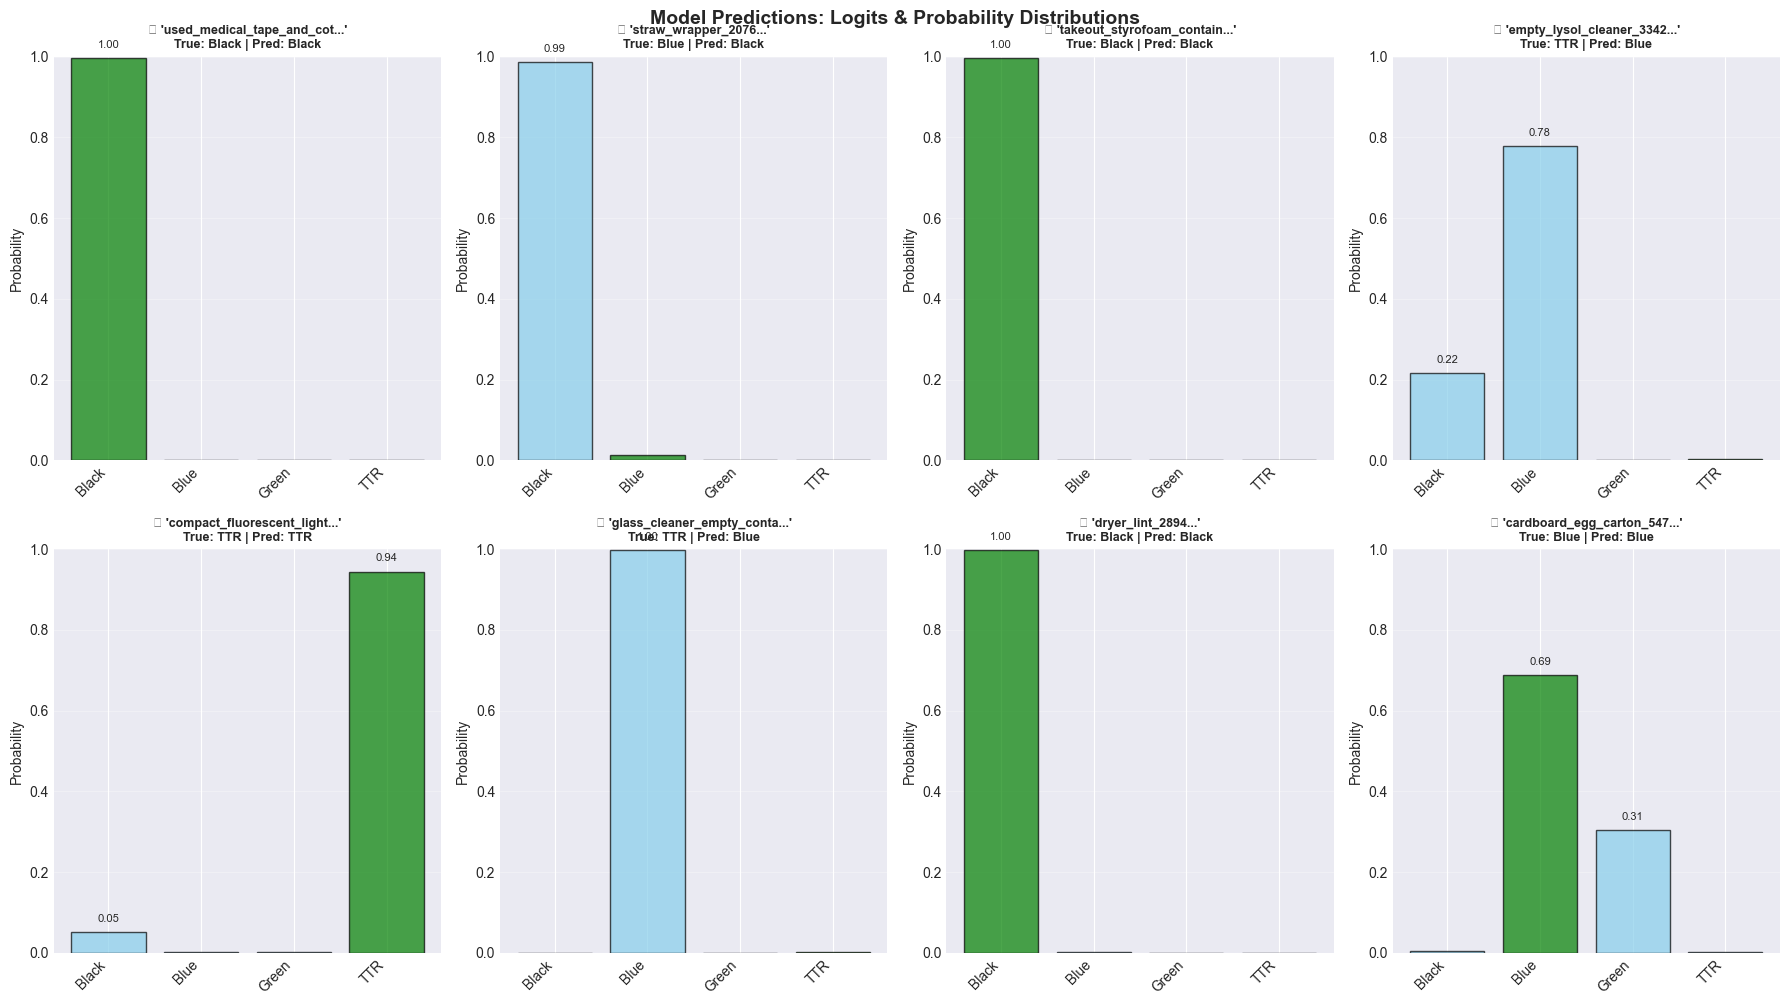


DETAILED OUTPUT FOR FIRST TEST SAMPLE
Text: 'used_medical_tape_and_cotton_ball_150'
True Label: Black

Raw Logits (pre-softmax weights):
  Black     :   5.2749
  Blue      :  -1.8239
  Green     :  -2.6814
  TTR       :  -1.1035

Probability Distribution (post-softmax):
  Black     : 0.9971 ( 99.71%)
  Blue      : 0.0008 (  0.08%)
  Green     : 0.0003 (  0.03%)
  TTR       : 0.0017 (  0.17%)

Predicted Class: Black
Confidence: 99.71%
Status: ✓ CORRECT


In [26]:
# Get some test samples
num_samples = 8
sample_indices = np.random.choice(len(test_df), num_samples, replace=False)

# Get the texts and labels
test_texts = [test_df.iloc[idx]["text"] for idx in sample_indices]
test_labels = [test_df.iloc[idx]["label"] for idx in sample_indices]

# Get predictions with both logits and probabilities
logits, probs = get_predictions(
    model, test_texts, tokenizer, device, return_type="both"
)

# Display results for all samples
fig, axes = plt.subplots(2, 4, figsize=(18, 10))
axes = axes.ravel()

for i in range(num_samples):
    # Get probability distribution for this sample
    prob_values = probs[i].cpu().numpy()
    logit_values = logits[i].cpu().numpy()

    x_pos = np.arange(len(class_names))
    colors = [
        "green" if j == test_labels[i] else "skyblue" for j in range(len(class_names))
    ]

    axes[i].bar(x_pos, prob_values, color=colors, alpha=0.7, edgecolor="black")
    axes[i].set_xticks(x_pos)
    axes[i].set_xticklabels(class_names, rotation=45, ha="right")
    axes[i].set_ylabel("Probability", fontsize=10)
    axes[i].set_ylim([0, 1])

    # Determine if prediction is correct
    predicted_class = torch.argmax(probs[i]).item()
    true_class = class_names[test_labels[i]]
    pred_class = class_names[predicted_class]
    is_correct = predicted_class == test_labels[i]
    status = "✓" if is_correct else "✗"

    axes[i].set_title(
        f"{status} '{test_texts[i][:25]}...'\nTrue: {true_class} | Pred: {pred_class}",
        fontweight="bold",
        fontsize=9,
    )
    axes[i].grid(True, alpha=0.3, axis="y")

    # Add probability values on bars
    for j, v in enumerate(prob_values):
        if v > 0.05:  # Only show labels for probabilities > 5%
            axes[i].text(j, v + 0.02, f"{v:.2f}", ha="center", va="bottom", fontsize=8)

plt.tight_layout()
plt.suptitle(
    "Model Predictions: Logits & Probability Distributions",
    fontsize=14,
    fontweight="bold",
    y=1.00,
)
plt.show()

# Print detailed output for first sample
print("\n" + "=" * 80)
print("DETAILED OUTPUT FOR FIRST TEST SAMPLE")
print("=" * 80)
print(f"Text: '{test_texts[0]}'")
print(f"True Label: {class_names[test_labels[0]]}")
print(f"\nRaw Logits (pre-softmax weights):")
for i, class_name in enumerate(class_names):
    print(f"  {class_name:10s}: {logits[0][i].item():8.4f}")

print(f"\nProbability Distribution (post-softmax):")
for i, class_name in enumerate(class_names):
    print(
        f"  {class_name:10s}: {probs[0][i].item():.4f} ({probs[0][i].item()*100:6.2f}%)"
    )

predicted_class_idx = torch.argmax(probs[0]).item()
print(f"\nPredicted Class: {class_names[predicted_class_idx]}")
print(f"Confidence: {torch.max(probs[0]).item()*100:.2f}%")

# Check if correct
is_correct = predicted_class_idx == test_labels[0]
print(f"Status: {'✓ CORRECT' if is_correct else '✗ INCORRECT'}")
print("=" * 80)